In [337]:
import re
import shutil
import os
import random
import time
from datetime import datetime
import pdb
import math
import uuid

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import PIL.Image
from PIL import Image
import cv2
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

matplotlib.style.use('ggplot')
torch.multiprocessing.set_sharing_strategy('file_system')


In [3]:
# CONSTANTES
LABBELS_NAMES = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']

## 1. FUNCIONES PARA CARGAR Y DIVIDIR ARCHIVOS

In [4]:
# Se crea un archivo en la direccion ingresada, esta se elimina si ya existe.
def create_folder( folder_name, dest_path ):
    try:
        folder_path = dest_path+'/'+folder_name
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)   
        os.mkdir(folder_path)
        return True
    except OSError as err:
        print("OS error:", err)

In [5]:
# Se crea un archivo en la direccion ingresada
def create_folder_wremoving( folder_name, dest_path ):
    try:
        folder_path = dest_path+folder_name
        if not(os.path.exists(folder_path)):
            os.mkdir(folder_path)
        return True
    except OSError as err:
        print("OS error:", err)

In [6]:
# Se crea el data-set a partir de la informacion presente en expertAnotations.txt, y las partialImages de entrada.
def create_dataset(path_expertAnotations,path_partialImages, dest_path, dataset_name):
    try:
        file = open(path_expertAnotations, 'r')
        create_folder(dataset_name, dest_path)
        for labbel_name in LABBELS_NAMES:
            create_folder( labbel_name ,dest_path+'/'+dataset_name)
        for x in file:
            # Se obtiene el nombre y clase desde el archivo txt
            aux1 = x.split('	')
            aux2 = aux1[0].replace('\n','').split('-')
            aux3 = aux2[2].split('/')
            clase = int(aux1[4].replace('\n',''))
            p = aux2[0]
            pl = aux2[1]
            n_sample = int(re.split('(\d+)',aux3[0])[1])
            n_sperm = int(re.split('(\d+)',aux3[1])[1])
            # Se conforma el directorio de la imagen a partir de la informacion anterior.
            file = path_partialImages+'ch00_'+p+'-'+pl+'-sample'+str(n_sample)+'-sperm'+str(n_sperm)+'.tif'
            # Se conforma el directorio donde se va a copiar la imagen
            aux = dest_path+'/'+dataset_name+'/'
            if (clase == 0):
                aux=aux+'01-Normal'
            elif (clase == 1):
                aux=aux+'02-Tapered'
            elif (clase == 2):
                aux=aux+'03-Pyriform'
            elif (clase == 3):
                aux=aux+'04-Small'
            else:
                aux=aux+'05-Amorphous'
            # Se copia la imagen
            shutil.copy(file,aux)  
        return True
    except OSError as err:
        print("OS error:", err)
    

In [7]:
def copy_element(origin_path, dest_path):
    try:
        shutil.copy( origin_path, dest_path)
        return True
    except OSError as err:
        print("OS error:", err)

In [8]:
# Elige aleatoriamente un elemento de la lista, y luego lo elimina de esta.
def choose_random_element(elements_list):
    element = random.choice(elements_list)
    elements_list.remove(element)
    return element

In [9]:
# Se crean los conjuntos train, valid y test a partir de las imagenes.
def create_train_valid_test( origin_path, dest_path, dataset_name,porcentages):
    create_folder(dataset_name, dest_path)
    dataset_path = dest_path+'/'+dataset_name
    create_folder('train', dataset_path)
    create_folder('test', dataset_path)
    create_folder('valid', dataset_path)
    
    for labbel_name in LABBELS_NAMES:
        create_folder( labbel_name, dataset_path+'/train' )
        create_folder( labbel_name, dataset_path+'/test' )
        create_folder( labbel_name, dataset_path+'/valid' )
        try:
            all_class_images = os.listdir(origin_path+'/'+labbel_name)
            count_class_images = len(all_class_images)
            origin_class_path = origin_path+'/'+labbel_name
            # Archivos test
            aux_count = 0
            while int(count_class_images*porcentages[0]) > aux_count:
                image_name = choose_random_element(all_class_images)
                copy_element( origin_class_path+'/'+image_name, dataset_path+'/test/'+labbel_name+'/'+image_name)
                aux_count = aux_count+1
            aux_count = 0
            # Archivos valid
            while int(count_class_images*porcentages[1]) > aux_count:
                image_name = choose_random_element(all_class_images)
                copy_element( origin_class_path+'/'+image_name, dataset_path+'/valid/'+labbel_name+'/'+image_name)
                aux_count = aux_count+1
            aux_count = 0
             # Archivos train
            while len(all_class_images) != 0:
                image_name = choose_random_element(all_class_images)
                copy_element( origin_class_path+'/'+image_name, dataset_path+'/train/'+labbel_name+'/'+image_name)
        except OSError as err:
            print("OS error:", err)

In [10]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data_tf_format(data_path, batch_size, target_size):
    
    dataGen_train = ImageDataGenerator(rescale = 1./255) 
    dataGen_valid = ImageDataGenerator(rescale = 1./255)
    dataGen_test = ImageDataGenerator(rescale = 1./255)

    #test different color maps -  class modes and cross validation types
    train = dataGen_train.flow_from_directory(data_path+'/train',
                                                     target_size = target_size,
                                                     batch_size = batch_size,
                                                     shuffle = True,
                                                     class_mode="categorical")

    valid = dataGen_valid.flow_from_directory(data_path+'/valid',
                                                target_size = target_size,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                class_mode="categorical")

    test = dataGen_test.flow_from_directory(data_path+'/test',
                                                target_size = target_size,
                                                batch_size = 1,
                                                shuffle = True,
                                                class_mode="categorical")
    return train,valid,test

In [741]:
def load_data_pytorch_format( dataset_path, batch_size, image_dimention ):
    
    transform = transforms.Compose([
        transforms.Resize(image_dimention[0]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(root=dataset_path+'/train', 
                                         transform=transform)
    valid_dataset = datasets.ImageFolder(root=dataset_path+'/valid',
                                         transform=transform)
    test_dataset = datasets.ImageFolder(root=dataset_path+'/test',
                                        transform=transform)    

    train_loader = DataLoader( train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=1, 
                              pin_memory=True)
    valid_loader = DataLoader( valid_dataset, 
                              batch_size=batch_size, 
                              shuffle=True,
                              num_workers=1, 
                              pin_memory=True)
    test_loader = DataLoader( test_dataset, 
                             batch_size=batch_size, 
                             shuffle=True,
                             num_workers=1, 
                             pin_memory=True)

    return train_loader, valid_loader, test_loader

# 2.FUNCIONES DE DEEP LEARNING

In [12]:
def random_init(m):
    if type(m)==nn.Linear or type(m)==nn.Conv2d:
        m.weight.data=torch.randn(m.weight.size())*.01

In [13]:
def train(net, trainloader, optimizer, criterion , device):
    net.train()
    running_loss = 0.0
    running_acc = 0.0
    count_minibatchs = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)
        running_acc += (preds == labels).sum().item()

        count_minibatchs = i+1
        
    epoch_loss = running_loss / count_minibatchs
    epoch_acc = 100. * (running_acc / len(trainloader.dataset))
    print(f"loss: {epoch_loss:.3f}, accuracy: {epoch_acc:.3f}")
    return epoch_loss, epoch_acc

In [14]:
def validate(net, validloader, criterion, device):
    net.eval()
    running_loss = 0.0
    running_acc = 0.0
    count_minibatchs = 0
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # forward
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            running_loss += loss.item()

            _, preds = torch.max(outputs.data, 1)
            running_acc += (preds == labels).sum().item()

            count_minibatchs = i+1
    epoch_loss = running_loss / count_minibatchs
    epoch_acc = 100. * (running_acc / len(validloader.dataset))
    print(f"val_loss: {epoch_loss:.3f}, val_accuracy: {epoch_acc:.3f}")
    return epoch_loss, epoch_acc


In [713]:
def test(net, testloader, device):
    y_pred, y_original = [], []
    for i, data in enumerate(testloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels

        # get original labbels
        y_original.extend(labels.numpy())

        # forward
        outputs=net(inputs)

        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu()
        y_pred.extend(preds.numpy())

    return y_pred,y_original

In [16]:
def load_model( net, model_state, device):
    net.load_state_dict( model_state )
    net.to(device)
    return net

In [17]:
def save_acc_plot(train_acc, valid_acc, model_save_path):
    try:
        plt.figure()
        plt.plot(train_acc, color='red', label='train acc')
        plt.plot(valid_acc, color='blue', label='valid acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig(model_save_path+'/accuracy.png')
        return True
    except:
        return False

In [18]:
def save_loss_plot(train_loss, valid_loss, model_save_path):
    try:
        plt.figure()
        plt.plot(train_loss, color='red', label='train loss')
        plt.plot(valid_loss, color='blue', label='valid loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(model_save_path+'/loss.png')    
        return True
    except:
        return False

In [780]:
def save_confusion_matrix(y_true, y_pred, model_save_path):
    cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    file= open(model_save_path+"/general_scores.txt","w+")
    file.write(f"Accuracy Score: {accuracy:.3f}\n")
    file.write(f"Precision Score: {precision:.3f}\n")
    file.write(f"Recall Score: {recall:.3f}\n")
    file.write(f"F1 Score: {f1:.3f}\n")
    file.close()
    
    df_cm = pd.DataFrame(cf_matrix, index = [class_name for class_name in LABBELS_NAMES], columns = [class_name for class_name in LABBELS_NAMES])
    plt.figure()
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.savefig(model_save_path+'/confusion_matrix.png')
    return accuracy, precision, recall, f1, cf_matrix


In [728]:
def process_net( net, epochs, trainloader, validloader, testloader, optimizer, criterion, model_save_path):
    aux = copy.deepcopy(net)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    train_loss, valid_loss ,train_acc, valid_acc = [],[],[],[]
    
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    
    net = net.to(device)
    best_vloss = float('inf')
    best_model_state= []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_epoch_loss, train_epoch_acc = train(net, trainloader, optimizer, criterion,device)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)

        valid_epoch_loss, valid_epoch_acc = validate(net, validloader, criterion,device)        
        valid_loss.append(valid_epoch_loss)
        valid_acc.append(valid_epoch_acc)

        if valid_epoch_loss < best_vloss:
            best_vloss = valid_epoch_loss
            best_model_state = net.state_dict()
        print("\n\n")
        time.sleep(1)
        
    best_net = load_model( aux, best_model_state, device)
    time.sleep(1.5)
    y_pred,y_true = test(best_net, testloader, device)
    save_acc_plot(train_acc, valid_acc, model_save_path)
    save_loss_plot(train_loss, valid_loss, model_save_path)
    accuracy, precision, recall, f1, matrix = save_confusion_matrix(y_true, y_pred, model_save_path)
    
    return accuracy, precision, recall, f1, matrix

# 3. FUNCIONES PARA ELIMINAR BORDES NEGROS

In [113]:
def fill_with_white_pixels( imag, pixel_list ):
    for element in pixel_list:
        i = element[0]
        j = element[1]
        imag.putpixel((i,j), 255)
    

In [22]:
def get_most_frecuent_value( arr ):
    count = 0
    aux = arr[0]
    for i in range(len(arr)-1):
        frec = arr.count(arr[i])
        if(frec > count):
            count = frec
            aux = arr[i]
    return aux

In [23]:
def remove_elements(arr, element):
    return [x for x in arr if x != element]


In [221]:
def get_most_common_values( all_pixels ):
    all_pixels = remove_elements(all_pixels, 0)

    new_value1 = get_most_frecuent_value(all_pixels)
    all_pixels = remove_elements(all_pixels, new_value1)
    aux1 = new_value1
    
    return [aux1-1,aux1,aux1+1]

In [207]:
def get_black_dots( img, i, j ):
    rows, cols = img.size
    list_elements = []
    list_elements.append([i,j])
    list_blackdots = []
    for element in list_elements:
        i = element[0]
        j = element[1]
        if( i < rows and j < cols and i >= 0 and j >= 0  ):
            pixel =  img.getpixel((i,j))
            if( pixel == 0  and ([i,j] not in list_blackdots) ):
                list_blackdots.append([i,j])
                list_elements.extend([[i-1,j-1], [i-1,j], [i-1,j+1], [i,j-1], [i,j+1], [i+1,j-1], [i+1,j], [i+1,j+1]])
    return list_blackdots

In [208]:
def get_near_dots( img, black_dots ):
    rows, cols = img.size
    list_near_dots = []
    search_x_y_operations = [[-1,-1], [-1,0], [-1,+1], [0,-1], [0,+1], [+1,-1], [+1,0],[+1,+1]]
    if len(black_dots) != 0:
        for dot in black_dots:
            i = dot[0]
            j = dot[1]
            for operation in search_x_y_operations:
                operation_x = operation[0]
                operation_y = operation[1]
                aux_i = i+operation_x
                aux_j = j+operation_y
                if( (aux_i < rows and aux_j < cols and aux_i >= 0 and aux_j >= 0) ):
                    pixel = img.getpixel((aux_i,aux_j))
                    if ( pixel != 0  and ([aux_i,aux_j] not in list_near_dots) and ([aux_i,aux_j] not in black_dots) ):
                        list_near_dots.append( [aux_i,aux_j] )
                        
    return list_near_dots
        

In [209]:
def get_dots_from_background( imag, i, j ):
    rows, cols = imag.shape
    list_near_pixels = []    
    search_x_y_operations = [[-1,-1], [-1,0], [-1,+1], [0,-1], [0,+1], [+1,-1], [+1,0],[+1,+1]]
    for operation in search_x_y_operations:
        operation_x = operation[0]
        operation_y = operation[1]
        aux_i = i+operation_x
        aux_j = j+operation_y    
        if( (aux_i < rows and aux_j < cols and aux_i >= 0 and aux_j >= 0) ):
            pixel = image.getpixel((aux_i,aux_j))
            if ( pixel != 0  and (pixel not in list_near_pixels) ):
                list_near_pixels.append( pixel )    
    return list_near_pixels

In [210]:
def fill_with_random_pixels( imag, pixels ):
    rows, cols = imag.shape
    for i in range(rows):
        for j in range(cols):
            pixel = random.choice(pixels)
            imag[i,j] = pixel

In [211]:
def remove_under_bigger( arr ):
    bigger = max(arr)
    for element in arr:
        if ( element+30 < bigger ):
            arr.remove(element)

In [222]:
def remove_black_corners( original_data_path, dest_path ):
    create_folder('pre-process', dest_path)
    all_images_paths = os.listdir(original_data_path)
    for image_name in all_images_paths:
        img_gray = Image.open(original_data_path+'/'+image_name,mode='r')
        
        rows,cols = img_gray.size
        
        corners = [[0,0], [rows-1, 0], [0, cols-1], [rows-1, cols-1]]

        for corner in corners:
            base = np.zeros([rows,cols],dtype=np.uint8)
            i = corner[0]
            j = corner[1]
            pixels_black_dots = get_black_dots( img_gray, i, j)

            if len(pixels_black_dots) != 0:
    
                pixels_near_dots = get_near_dots( img_gray, pixels_black_dots )
                pixels_near_dots_layer_1 = get_near_dots( img_gray, pixels_near_dots )
                pixels_near_dots_layer_2 = get_near_dots( img_gray, pixels_near_dots_layer_1 )
                
                dots_from_background = get_near_dots( img_gray, pixels_near_dots_layer_2 )
                pixels_from_background = []
                
                for dot in dots_from_background:
                    i = dot[0]
                    j = dot[1]
                    pixel = img_gray.getpixel((i,j))
                    pixels_from_background.append(pixel)
                    
                remove_under_bigger( pixels_from_background )
                
                common_pixels = get_most_common_values( pixels_from_background )
                fill_with_random_pixels( base, common_pixels )

                fill_with_white_pixels(img_gray, pixels_black_dots)
                fill_with_white_pixels(img_gray, pixels_near_dots)
                fill_with_white_pixels(img_gray, pixels_near_dots_layer_1)
                fill_with_white_pixels(img_gray, pixels_near_dots_layer_2)

                arr1 = np.array(img_gray)

                #mask1_image = (img_gray < 255)
                
                mask1_image = arr1[:,:] < 255
                mask2_image = arr1[:,:] == 255
                
                #mask2_image = (img_gray == 255)

                image_1 = img_gray *mask1_image
                image_2 = base *mask2_image
            
                final = image_1 + image_2
                
                img_gray = Image.fromarray(final.astype(np.uint8))
                
        img_gray.save( dest_path+'/pre-process/'+image_name )


In [223]:
main_path = '/home/mcoronado/Escritorio/Codigo-Memoria/'
remove_black_corners( main_path+'Data-set/Partial-Agreement-Images/', main_path+'Data-set' )

# 4. TECNICA DE AUMENTO DE DATOS: RANDAUGMENT

In [33]:
def extend_image( image, size ):
    rows, cols = image.size
    nrows, ncols = rows+size*2, cols+size*2
    base = np.zeros([nrows,ncols],dtype=np.uint8)
    
    for i in range(nrows):
        for j in range(ncols):
            base[i,j] = 254
            
    # copy image
    for i in range(rows):
        for j in range(cols):
            base[i+size,j+size] = image.getpixel((j,i))
            
    # face 1
    for i in range(size):
        for j in range(cols):   
            base[size+j, size-i-1] = image.getpixel((i,j))
            
    # face 2
    for i in range(rows):
        for j in range(size):   
            base[size-j-1, size+i] = image.getpixel((i,j))    
    
    # face 3
    for i in range(rows-size ,rows):
        for j in range(cols):   
            base[size+j, size-i+2*rows-1] = image.getpixel((i,j))  

    # face 4
    for i in range(rows):
        for j in range(cols-size, cols):   
            base[size-j+2*cols-1, size+i] = image.getpixel((i,j))
    final = Image.fromarray(base)
    return final  

In [748]:
def TranslateX(img, v): 
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]

    o_w, o_h = img.size
    img = extend_image( img , 10 )
    
    w, h = img.size
    left = (w - o_w)/2
    top = (h - o_h)/2
    right = (w + o_w)/2
    bottom = (h + o_h)/2    
    
    
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0)).crop((left, top, right, bottom))


def TranslateY(img, v): 
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    
    o_w, o_h = img.size
    img = extend_image( img , 10 )
    
    w, h = img.size
    left = (w - o_w)/2
    top = (h - o_h)/2
    right = (w + o_w)/2
    bottom = (h + o_h)/2
    
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v)).crop((left, top, right, bottom))


def Rotate(img, v):
    if random.random() > 0.5:
        v = -v
    o_w, o_h = img.size
    img = extend_image( img , 10 )
    
    w, h = img.size
    left = (w - o_w)/2
    top = (h - o_h)/2
    right = (w + o_w)/2
    bottom = (h + o_h)/2
    
    return img.rotate(v, resample=Image.BILINEAR).crop((left, top, right, bottom))


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Flip(img, _): 
    return PIL.ImageOps.flip(img)


def Solarize(img, v): 
    return PIL.ImageOps.solarize(img, v)

def Posterize(img, v):
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Brightness(img, v):
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def Identity(img, v):
    return img


def is_x_in_list( x, arr ):
    for element in arr:
        if element == x:
            return True
    return False

def get_n_random_elements( arr, n):
    if len(arr) >= n:
        out_arr = []
        while len(out_arr) != n:
            element = random.choice(arr)
            if not( is_x_in_list( element, out_arr ) ):
                out_arr.append(element)
        return out_arr
    else:
        return []

def augment_list():
    arr_augment = [
        (TranslateX, 0., 0.15),
        (TranslateY, 0., 0.15),
        (Rotate, 0, 50),
        (AutoContrast, 0, 1),
        (Invert, 0, 1),
        (Flip, 0, 1),
        (Solarize, 0, 256),
        (Contrast, 0.1, 2),
        (Brightness, 0.1, 2),
        (Sharpness, 0.1, 2),
    ]
    return arr_augment
        
class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = get_n_random_elements( self.augment_list, n=self.n )
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img

# 5. TECNICA DE AUMENTO DE DATOS: GRIDMASK

In [225]:
class Grid(object):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        self.d1 = d1
        self.d2 = d2
        self.rotate = rotate
        self.ratio = ratio
        self.mode=mode
        self.st_prob = self.prob = prob

    def set_prob(self, epoch, max_epoch):
        self.prob = self.st_prob * min(1, epoch / max_epoch)

    def __call__(self, img):
        convert_tensor = transforms.ToTensor()
        convert_PIL = transforms.ToPILImage()
        img = convert_tensor(img)
        if np.random.rand() > self.prob:
            return img
        
        h = img.size(1)
        w = img.size(2)  
        hh = math.ceil((math.sqrt(h*h + w*w)))
        d = np.random.randint(self.d1, self.d2)
        self.l = math.ceil(d*self.ratio)
        
        mask = np.ones((hh, hh), np.float32)
        st_h = np.random.randint(d)
        st_w = np.random.randint(d)
        for i in range(-1, hh//d+1):
                s = d*i + st_h
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[s:t,:] *= 0
        for i in range(-1, hh//d+1):
                s = d*i + st_w
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[:,s:t] *= 0
        r = np.random.randint(self.rotate)
        mask = Image.fromarray(np.uint8(mask))
        mask = mask.rotate(r)
        mask = np.asarray(mask)
        mask = mask[(hh-h)//2:(hh-h)//2+h, (hh-w)//2:(hh-w)//2+w]

        mask = torch.from_numpy(mask).float()
        if self.mode == 1:
            mask = 1-mask

        mask = mask.expand_as(img)
        img = img * mask 
        
        img = convert_PIL(img)
        return img


# 6. TECNICA DE AUMENTO DE DATOS: SMOOTHMIX

In [247]:
def calculate_images_per_class( classes_dir, n):
    images_per_class = []
    for class_name in LABBELS_NAMES:
        all_images = os.listdir(classes_dir+'/'+class_name)
        aux = n - len(all_images)
        if aux < 0:
            aux = 0
        images_per_class.append(aux)
    return images_per_class

In [262]:
def folder_have_augmented_images( folder_dir ):
    file_names = os.listdir(folder_dir)
    for name in file_names:
        if not name.endswith('tif'):
            return True
    return False
    

In [363]:
def augment_class_with_randaugment( n, m, class_dir , class_augmentation_goal ):
    images_names = os.listdir(class_dir)
    rand = RandAugment(n,m)
    class_current_files = len(images_names)
    
    while  class_augmentation_goal > class_current_files:
        for image_name in images_names:
            if random.random() > 0.5:
                dir_image = class_dir+'/'+image_name
                if dir_image.endswith('tif'):
                    image = Image.open(dir_image,mode='r')
                    augmented_image = rand(image)
                    filename = str(uuid.uuid4())
                    augmented_image.save(class_dir+'/output/'+filename+image_name)
                    class_current_files = class_current_files+1
                    if class_augmentation_goal >= class_current_files:
                        break



# BLOQUE PRINCIPAL

In [700]:
main_path = '/home/mcoronado/Escritorio/Codigo-Memoria/'
raw_dataset_name = 'raw_data'
dataset_name = 'data'
pre_process_dataset_name = 'pre-process'

test_porcentage = 0.3
valid_porcentage = 0.7*0.2
train_porcentage = 0.7*0.8

image_dimention = (35,35)
batch_size = 64
learning_rate = 0.001
epochs = 30

# Pre-process data
remove_black_corners( main_path+'Data-set/Partial-Agreement-Images/', main_path+'Data-set' )

create_dataset(path_expertAnotations = main_path+'Data-set/PA-expert-annotations.txt', 
              path_partialImages = main_path+'Data-set/'+pre_process_dataset_name+'/',
              dest_path = main_path+'Data-set',
              dataset_name = raw_dataset_name)


create_train_valid_test(origin_path=main_path+'Data-set/'+raw_dataset_name,
                        dest_path=main_path+'Data-set/',
                        dataset_name = dataset_name,
                        porcentages = [test_porcentage,valid_porcentage,train_porcentage])

dataset_path = main_path+'Data-set/'+dataset_name

augmented_images_per_class = calculate_images_per_class( dataset_path+'/train' ,1000)


In [ ]:
#net = models.resnet34()
#net = models.resnet50()
#net = models.vgg19()
#net = models.densenet161()
#net = models.densenet169()


net = models.resnet18()
model_name = 'resnet50_random'

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model_path = main_path+'outputs/'+model_name
create_folder_wremoving('outputs', main_path)
create_folder_wremoving(model_name, main_path+'outputs/')

#net.apply(random_init) #Model here is the model that you have created

process_net( net , epochs, trainloader, validloader, testloader, optimizer, criterion, model_path)

In [535]:
main_path = '/home/mcoronado/Escritorio/Codigo-Memoria/'
raw_dataset_name = 'raw_data'
dataset_name = 'data'
pre_process_dataset_name = 'pre-process'

test_porcentage = 0.3
valid_porcentage = 0.7*0.2
train_porcentage = 0.7*0.8

image_dimention = (35,35)
batch_size = 64
learning_rate = 0.001
epochs = 30

# Pre-process data
remove_black_corners( main_path+'Data-set/Partial-Agreement-Images/', main_path+'Data-set' )

create_dataset(path_expertAnotations = main_path+'Data-set/PA-expert-annotations.txt', 
              path_partialImages = main_path+'Data-set/'+pre_process_dataset_name+'/',
              dest_path = main_path+'Data-set',
              dataset_name = raw_dataset_name)



True

In [464]:
def generate_empty_arr( n ):
    arr = []
    for i in range(n):
        arr.append([])
    return arr

In [504]:
def split_data_into_k_folds( data_path, k_folds):
    all_folds_data = generate_empty_arr(k_folds)
    percentage_per_fold = (100/k_folds)/100
    for class_name in LABBELS_NAMES:
        class_path = data_path+'/'+class_name
        class_images = os.listdir(class_path)
        count_class_images = len(class_images)
        for k in range( k_folds ):
            fold_data = []
            aux_count = 0
            while int(count_class_images*percentage_per_fold) > aux_count:
                image_name = choose_random_element(class_images)
                fold_data.append( [image_name, class_name])
                aux_count = aux_count+1
            all_folds_data[k].extend( fold_data )
        while (len(class_images) != 0 ):
            i_fold = random.randint(0, k_folds-1)
            image_name = choose_random_element(class_images)
            all_folds_data[i_fold].append([image_name,class_name])
    return all_folds_data

In [674]:
def get_kfold_train_test_data( k_fold_list, k_fold ):
    train_fold_data = []
    test_fold_data = []
    for i in range( len(k_fold_list) ):
        k_fold_data = k_fold_list[i]
        if i == k_fold:
            test_fold_data.extend( k_fold_data )
        else:
            train_fold_data.extend( k_fold_data )
    return train_fold_data, test_fold_data

In [694]:
def copy_images_to_kfold_folders( k_fold_data , root_path ,dataset_folder_name, k_fold_folder_name ):
    AUX_NAMES = ['train', 'test']
    create_folder( k_fold_folder_name , root_path)
    for element in AUX_NAMES:
        create_folder( element, root_path+'/'+k_fold_folder_name)
        for labbel in LABBELS_NAMES:
            create_folder( labbel, root_path+'/'+k_fold_folder_name+'/'+element )
    
    for i in range( len(k_fold_data) ):
        fold = k_fold_data[i]
        folder_name = AUX_NAMES[i]
        for element in fold:
            image_name, image_class = element[0],element[1]
            image_dir = root_path+dataset_folder_name+'/'+image_class+'/'+image_name
            image_dest = root_path+'/'+k_fold_folder_name+'/'+folder_name+'/'+image_class+'/'+image_name
            copy_element( image_dir, image_dest )
        
    

In [742]:
def load_data_pytorch_kfold_format( dataset_path, batch_size, image_dimention ):
    
    transform = transforms.Compose([
        transforms.Resize(image_dimention[0]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(root=dataset_path+'/train', 
                                         transform=transform)
    test_dataset = datasets.ImageFolder(root=dataset_path+'/test',
                                        transform=transform)    

    train_loader = DataLoader( train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=4, 
                              pin_memory=True)
    
    test_loader = DataLoader( test_dataset, 
                             batch_size=batch_size, 
                             shuffle=True,
                             num_workers=4, 
                             pin_memory=True)

    return train_loader, test_loader

In [852]:
def save_confusion_kfold_matrix(y_true, y_pred, model_save_path):
    cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1, cf_matrix


In [854]:
def process_net_kfold( net, epochs, trainloader, testloader, optimizer, criterion, model_save_path):

    train_loss, valid_loss ,train_acc, valid_acc = [],[],[],[]
    
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    
    net = net.to(device)
    best_vloss = float('inf')
    best_model_state= []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_epoch_loss, train_epoch_acc = train(net, trainloader, optimizer, criterion,device)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        time.sleep(1)

    y_pred,y_true = test(net, testloader, device)
    
    accuracy, precision, recall, f1, matrix = save_confusion_kfold_matrix(y_true, y_pred, model_save_path)
    
    return accuracy, precision, recall, f1, matrix, train_loss, train_acc

In [770]:
def get_mean_from_history( history, element ):
    all_data = history[element]
    mean = 0
    for data in all_data:
        mean = mean + data
    return mean/len(all_data)

In [849]:
def save_loss(history, model_save_path):
    try:
        plt.figure()
        loss = history['train_loss']
        colors = [ 'blue', 'orange', 'red', 'purple', 'cyan', 'olive' ]
        plt.figure()
        for i in range(len(loss)):
            name = 'loss fold '+str(i+1)
            color = colors[i]
            plt.plot(loss[i], color=color, label=name)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()      
        plt.savefig(model_save_path+'/loss.png')
        return True
    except:
        return False

In [850]:
def save_acc(history, model_save_path):
    try:
        plt.figure()
        loss = history['train_acc']
        colors = [ 'blue', 'orange', 'red', 'purple', 'cyan', 'olive' ]
        plt.figure()
        for i in range(len(loss)):
            name = 'acc fold '+str(i+1)
            color = colors[i]
            plt.plot(loss[i], color=color, label=name)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()      
        plt.savefig(model_save_path+'/acc.png')
        return True
    except:
        return False

In [847]:
def save_k_fold_statistics( history,  model_save_path):
    
    accuracy = get_mean_from_history( history, 'acc')
    precision = get_mean_from_history( history, 'prec')
    recall = get_mean_from_history( history, 'recall')
    f1 = get_mean_from_history( history, 'f1')
    matrix = get_mean_from_history( history, 'matrix' )
    
    file= open(model_save_path+"/general_scores.txt","w+")
    file.write(f"Accuracy Score: {accuracy:.3f}\n")
    file.write(f"Precision Score: {precision:.3f}\n")
    file.write(f"Recall Score: {recall:.3f}\n")
    file.write(f"F1 Score: {f1:.3f}\n")
    file.close()
    
    save_loss(history, model_save_path)
    save_acc(history, model_save_path)
    
    df_cm = pd.DataFrame(matrix, index = [class_name for class_name in LABBELS_NAMES], columns = [class_name for class_name in LABBELS_NAMES])
    plt.figure()
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.savefig(model_save_path+'/confusion_matrix.png')
    
    
    

In [726]:
k_folds_partitons = 5

k_fold_folder = 'k_folds'

original_dataset_name = 'raw_data'

k_fold_dataset_path = main_path+'Data-set/'+k_fold_folder

k_fold_list = split_data_into_k_folds( main_path+'Data-set/'+raw_dataset_name, k_folds_partitons )


In [ ]:
import copy
######### RAND AUGMENT #########
# Busqueda en grilla
max_n = 10
max_m = 30
epochs = 50

resnet18 = models.resnet18()
resnet18.apply(random_init) 

history = {}
create_folder_wremoving('outputs', main_path)

timestamp_inicio = datetime.now().strftime('%Y%m%d_%H%M%S')
print( timestamp_inicio )
for n in range(1,max_n+1):
    for m in range(1,max_m+1):
        history = {'acc': [], 'prec': [],'recall':[],'f1':[], 'matrix':[], 'train_loss':[], 'train_acc':[]}
        for k_fold in range(k_folds_partitons):
            print('K Fold '+str(k_fold+1)+'\n')
            
            train_fold_data, test_fold_data = get_kfold_train_test_data( k_fold_list, k_fold)
            copy_images_to_kfold_folders( [train_fold_data, test_fold_data] , root_path ,original_dataset_name, k_fold_folder )

            for i in range(len(LABBELS_NAMES)):
                class_name = LABBELS_NAMES[i]
                class_dir = k_fold_dataset_path+'/train/'+class_name
                class_augmentation_goal = augmented_images_per_class[i]
                create_folder( 'output', class_dir  )
                augment_class_with_randaugment( n, m, class_dir , class_augmentation_goal )

            trainloader, testloader = load_data_pytorch_kfold_format( k_fold_dataset_path, batch_size, image_dimention)
            net = copy.deepcopy(resnet18)

            optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()

            k_accuracy, k_precision, k_recall, k_f1, k_matrix, k_train_loss, k_train_acc  = process_net_kfold( net , epochs, trainloader, testloader, optimizer, criterion, model_path)
            history['acc'].append(k_accuracy)
            history['prec'].append(k_precision)
            history['recall'].append(k_recall)
            history['f1'].append(k_f1)
            history['matrix'].append(k_matrix)
            history['train_loss'].append( k_train_loss )
            history['train_acc'].append( k_train_acc )
            
        model_name = 'resnet18_n'+str(n)+'_m'+str(m)
        create_folder_wremoving(model_name, main_path+'outputs/')
        model_path = main_path+'outputs/'+model_name
        save_k_fold_statistics( history, model_path)
        
timestamp_final = datetime.now().strftime('%Y%m%d_%H%M%S')
print( timestamp_final )


20221113_034400
K Fold 1



/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  
/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.


Epoch 1/50
loss: 1.411, accuracy: 50.953
Epoch 2/50
loss: 0.733, accuracy: 73.662
Epoch 3/50
loss: 0.541, accuracy: 80.551
Epoch 4/50
loss: 0.530, accuracy: 82.113
Epoch 5/50
loss: 0.385, accuracy: 86.728
Epoch 6/50
loss: 0.312, accuracy: 89.483
Epoch 7/50
loss: 0.355, accuracy: 87.945
Epoch 8/50
loss: 0.357, accuracy: 88.106
Epoch 9/50
loss: 0.343, accuracy: 89.070
Epoch 10/50
loss: 0.282, accuracy: 90.126
Epoch 11/50
loss: 0.212, accuracy: 92.606
Epoch 12/50
loss: 0.204, accuracy: 92.951
Epoch 13/50
loss: 0.188, accuracy: 93.777
Epoch 14/50
loss: 0.229, accuracy: 91.780
Epoch 15/50
loss: 0.156, accuracy: 94.466
Epoch 16/50
loss: 0.154, accuracy: 94.259
Epoch 17/50
loss: 0.148, accuracy: 94.282
Epoch 18/50
loss: 0.132, accuracy: 94.994
Epoch 19/50


In [ ]:
#### ORIGINAL - NO MODIFICAR -

In [782]:
import copy
######### RAND AUGMENT #########
# Busqueda en grilla
max_n = 10
max_m = 30
ops = []

best_accuracy = -1_000_000
best_precision = -1_000_000
best_recall = -1_000_000
best_f1 = -1_000_000
grid_elements = [[-1,-1], [-1,-1], [-1,-1], [-1,-1]]

epochs = 5

resnet18 = models.resnet18()
resnet18.apply(random_init) 

for n in range(1,max_n+1):
    for m in range(1,max_m+1):
        for i in range(len(LABBELS_NAMES)):
            class_name = LABBELS_NAMES[i]
            class_dir = dataset_path+'/train/'+class_name
            class_augmentation_goal = augmented_images_per_class[i]
            
            create_folder( 'output', class_dir  )
            augment_class_with_randaugment( n, m, class_dir , class_augmentation_goal )
    
        trainloader, validloader, testloader = load_data_pytorch_format( dataset_path, batch_size, image_dimention)
        
        net = copy.deepcopy(resnet18)
        
        model_name = 'resnet18_n'+str(n)+'_m'+str(m)
        
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        model_path = main_path+'outputs/'+model_name
        create_folder_wremoving('outputs', main_path)
        create_folder_wremoving(model_name, main_path+'outputs/')

        accuracy, precision, recall, f1, matrix  = process_net( net , epochs, trainloader, validloader, testloader, optimizer, criterion, model_path)
        
        # best accuracy
        if( accuracy > best_accuracy ):
            best_accuracy = accuracy
            grid_elements[0][0] = n
            grid_elements[0][1] = m
            
        # best precision
        if( precision > best_precision ):
            best_precision = precision
            grid_elements[1][0] = n
            grid_elements[1][1] = m
            
        # best recall
        if( recall > best_recall ):
            best_recall = recall
            grid_elements[2][0] = n
            grid_elements[2][1] = m
            
        # best f1
        if( f1 > best_f1 ):
            best_f1 = f1
            grid_elements[3][0] = n
            grid_elements[3][1] = m

      


/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  
/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.


KeyboardInterrupt: 

In [ ]:
print( grid_elements )

In [378]:
print( grid_elements )

[[7, 23], [9, 27], [7, 23], [6, 5]]


In [515]:
import copy

Epoch 1/15
loss: 5.938, accuracy: 25.625
val_loss: 6.619, val_accuracy: 1.290



Epoch 2/15
loss: 3.340, accuracy: 56.563
val_loss: 5.451, val_accuracy: 20.000



Epoch 3/15
loss: 2.037, accuracy: 64.688
val_loss: 4.559, val_accuracy: 20.000



Epoch 4/15
loss: 1.288, accuracy: 70.781
val_loss: 3.820, val_accuracy: 20.000



Epoch 5/15
loss: 0.800, accuracy: 79.688
val_loss: 3.512, val_accuracy: 21.935



Epoch 6/15
loss: 0.566, accuracy: 87.500
val_loss: 1.997, val_accuracy: 44.516



Epoch 7/15
loss: 0.356, accuracy: 90.469
val_loss: 1.491, val_accuracy: 58.065



Epoch 8/15
loss: 0.228, accuracy: 95.000
val_loss: 1.551, val_accuracy: 60.645



Epoch 9/15
loss: 0.137, accuracy: 97.812
val_loss: 1.271, val_accuracy: 62.581



Epoch 10/15
loss: 0.119, accuracy: 96.875
val_loss: 1.534, val_accuracy: 59.355



Epoch 11/15
loss: 0.123, accuracy: 97.031
val_loss: 1.485, val_accuracy: 59.355



Epoch 12/15
loss: 0.059, accuracy: 99.062
val_loss: 1.595, val_accuracy: 59.355



Epoch 13/15
lo

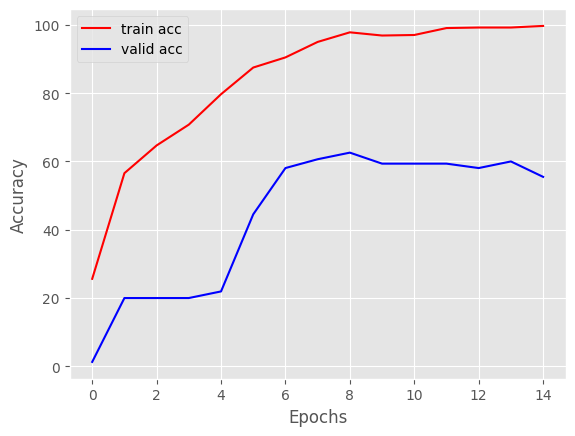

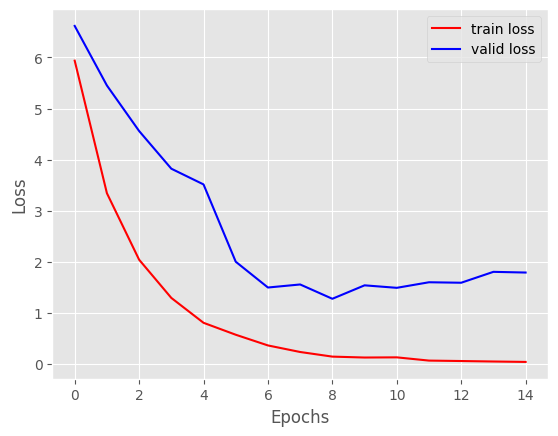

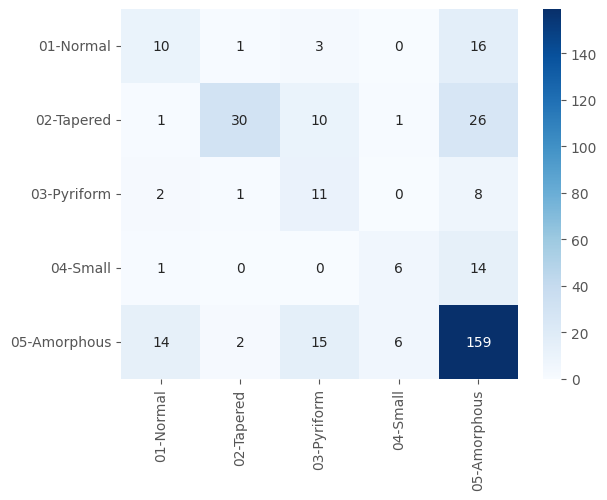